In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
from functools import partial
from math import log, sqrt, exp, isclose
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm, t
import scipy

# Constants
current_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15)
T = (expire_date - current_date).days / 365
S = 165
X = 165
implied_vol = 0.2
r = 0.0425
coupon = 0.0053
b = r - coupon

# Functions
def d1(S, X, T, implied_vol, b):
    return (np.log(S / X) + (b + implied_vol ** 2 / 2) * T) / (implied_vol * np.sqrt(T))

def d2(d1, T, implied_vol):
    return d1 - implied_vol * np.sqrt(T)

def greeks(option_type, S, X, T, implied_vol, r, b):
    call = 1 if option_type == "Call" else -1
    d_1 = d1(S, X, T, implied_vol, b)
    d_2 = d2(d_1, T, implied_vol)

    delta = call * norm.cdf(call * d_1, 0, 1)
    gamma = norm.pdf(d_1, 0, 1) / (S * implied_vol * np.sqrt(T))
    vega = S * norm.pdf(d_1, 0, 1) * np.sqrt(T)
    theta = -S * np.exp((b - r) * T) * norm.pdf(d_1, 0, 1) * implied_vol / (2 * np.sqrt(T)) \
            - (b - r) * S * np.exp((b - r) * T) * norm.cdf(call * d_1, 0, 1) * call \
            - r * X * np.exp(-r * T) * norm.cdf(call * d_2, 0, 1) * call
    rho = X * T * np.exp(-r * T) * norm.cdf(call * d_2, 0, 1) * call
    carry_rho = S * T * np.exp((b - r) * T) * norm.cdf(call * d_1, 0, 1) * call

    return delta, gamma, vega, theta, rho, carry_rho

# Calculations
option_types = ["Call", "Put"]
greeks_values = [greeks(option_type, S, X, T, implied_vol, r, b) for option_type in option_types]
delta, gamma, vega, theta, rho, carry_rho = zip(*greeks_values)

# Output
for i, option_type in enumerate(option_types):
    print(f"{option_type} Greeks:")
    print(f"  Delta: {delta[i]}")
    print(f"  Gamma: {gamma[i]}")
    print(f"  Vega: {vega[i]}")
    print(f"  Theta: {theta[i]}")
    print(f"  Rho: {rho[i]}")
    print(f"  Carry Rho: {carry_rho[i]}\n")


Call Greeks:
  Delta: 0.5342650692693474
  Gamma: 0.04005712070020568
  Vega: 19.71962666579851
  Theta: -24.898522316969515
  Rho: 7.583586080244792
  Carry Rho: 7.966245676523029

Put Greeks:
  Delta: -0.46573493073065264
  Gamma: 0.04005712070020568
  Vega: 19.71962666579851
  Theta: -18.786996965277233
  Rho: -7.277010958127815
  Carry Rho: -6.944415968299725



In [2]:
import numpy as np
from scipy.stats import norm
from datetime import datetime
import inspect

# Constants
current_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15)
T = (expire_date - current_date).days / 365
S = 165
X = 165
implied_vol = 0.2
r = 0.0425
coupon = 0.0053
b = r - coupon

# Functions
def d1(S, X, T, implied_vol, b):
    return (np.log(S / X) + (b + implied_vol ** 2 / 2) * T) / (implied_vol * np.sqrt(T))

def d2(d1, T, implied_vol):
    return d1 - implied_vol * np.sqrt(T)

def gbsm(option_type, S, X, T, implied_vol, r, b):
    call = 1 if option_type == "Call" else -1
    d_1 = d1(S, X, T, implied_vol, b)
    d_2 = d2(d_1, T, implied_vol)

    return call * (S * np.exp((b - r) * T) * norm.cdf(call * d_1, 0, 1) - X * np.exp(-r * T) * norm.cdf(call * d_2, 0, 1))

# Calculate first order derivative
def first_order_der(func, x, delta):
    return (func(x + delta) - func(x - delta)) / (2 * delta)

# Calculate second order derivative
def second_order_der(func, x, delta):
    return (func(x + delta) + func(x - delta) - 2 * func(x)) / delta ** 2

def cal_partial_derivative(func, order, arg_name, delta=1e-3):
    arg_names = list(inspect.signature(func).parameters.keys())
    derivative_fs = {1: first_order_der, 2: second_order_der}

    def partial_derivative(*args, **kwargs):
        args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
        arg_val = args_dict.pop(arg_name)

        def partial_f(x):
            p_kwargs = {arg_name: x, **args_dict}
            return func(**p_kwargs)

        return derivative_fs[order](partial_f, arg_val, delta)

    return partial_derivative

# Numerical Greeks
option_types = ["Call", "Put"]
greek_names = ['Delta', 'Gamma', 'Vega', 'Theta', 'Rho', 'Carry Rho']
greek_funcs = {
    'Delta': cal_partial_derivative(gbsm, 1, 'S'),
    'Gamma': cal_partial_derivative(gbsm, 2, 'S'),
    'Vega': cal_partial_derivative(gbsm, 1, 'implied_vol'),
    'Theta': cal_partial_derivative(gbsm, 1, 'T', delta=-1e-6),
    'Rho': cal_partial_derivative(gbsm, 1, 'r'),
    'Carry Rho': cal_partial_derivative(gbsm, 1, 'b')
}

greeks_values = {greek_name: [greek_func(option_type, S, X, T, implied_vol, r, b) for option_type in option_types] for greek_name, greek_func in greek_funcs.items()}

# Modify the Theta values to be negative
greeks_values['Theta'] = [-theta for theta in greeks_values['Theta']]

# Output Greeks values
for greek_name, values in greeks_values.items():
    print(f"{greek_name}:")
    for option_type, value in zip(option_types, values):
        print(f"  {option_type}: {value:.8f}")
    print()



Delta:
  Call: 0.53400912
  Put: -0.46551181

Gamma:
  Call: 0.04003793
  Put: 0.04003796

Vega:
  Call: 19.71017887
  Put: 19.71017887

Theta:
  Call: -24.89852231
  Put: -18.78699697

Rho:
  Call: -0.38265960
  Put: -0.33259499

Carry Rho:
  Call: 7.96624576
  Put: -6.94441590



In [3]:
def n_nodes(N):
    return (N + 2) * (N + 1) // 2

def node_index(i, j):
    return n_nodes(j - 1) + i

def binomial_tree_no_div(option_type, S0, X, T, implied_vol, r, N):
    is_call = 1 if option_type == "Call" else -1
    dt = T / N
    disc = np.exp(-r * dt)
    u = np.exp(implied_vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    C = np.empty(n_nodes(N), dtype=float)
            
    for i in np.arange(N, -1, -1):
        for j in range(i, -1, -1):
            S = S0 * u ** j * d ** (i - j)
            index = node_index(j, i)
            C[index] = max(0, (S - X) * is_call)
            if i < N:
                val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
                C[index] = max(C[index], val)
                
    return C[0]

def binomial_tree(option_type, S0, X, T, div_time, div, implied_vol, r, N):
    if div_time is None or div is None:
        return binomial_tree_no_div(option_type, S0, X, T, implied_vol, r, N)
  
    is_call = 1 if option_type == "Call" else -1
    dt = T / N
    disc = np.exp(-r * dt)
    
    #calculate u, d, and p
    u = np.exp(implied_vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    new_T = T - div_time * dt
    new_N = N - div_time

    C = np.empty(n_nodes(div_time), dtype=float)
    for i in range(div_time, -1, -1):
        for j in range(i, -1, -1):
            S = S0 * u ** j * d ** (i - j)
            val_exe = max(0, (S - X) * is_call)
            if i < div_time:
                val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
            else:
                val = binomial_tree(option_type, S - div, X, new_T, None, None, implied_vol, r, new_N)
            C[node_index(j, i)] = max(val_exe, val)
    
    return C[0]

In [4]:
# Assume N is 250
N = 250
value_no_div_call = binomial_tree_no_div("Call", S, X, T, implied_vol, r, N)
value_no_div_put = binomial_tree_no_div("Put", S, X, T, implied_vol, r, N)
print("Binomial tree value without dividend for call: " + str(value_no_div_call))
print("Binomial tree value without dividend for put: " + str(value_no_div_put))

Binomial tree value without dividend for call: 4.2708470346370015
Binomial tree value without dividend for put: 3.684796414938882


In [5]:
div_date = datetime(2022, 4, 11)
div = 0.88
div_time = int((div_date - current_date).days / (expire_date - current_date).days * N)

value_call = binomial_tree("Call", S, X, T, div_time, div, implied_vol, r, N)
value_put = binomial_tree("Put", S, X, T, div_time, div, implied_vol, r, N)
print("Binomial tree value with dividend for call: " + str(value_call))
print("Binomial tree value with dividend for put: " + str(value_put))

Binomial tree value with dividend for call: 4.113922557559131
Binomial tree value with dividend for put: 4.108753125967308


In [6]:
# delta
cal_amr_delta_num = cal_partial_derivative(binomial_tree, 1, 'S0')
delta_call_amr = cal_amr_delta_num("Call", S, X, T, div_time, div, implied_vol, r, N)
delta_put_amr = cal_amr_delta_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(delta_call_amr, delta_put_amr)

0.5362856902983992 -0.4905748584298486


In [7]:
# gamma
cal_amr_gamma_num = cal_partial_derivative(binomial_tree, 2, 'S0', delta=1)
gamma_call_amr = cal_amr_gamma_num("Call", S, X, T, div_time, div, implied_vol, r, N)
gamma_put_amr = cal_amr_gamma_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(gamma_call_amr, gamma_put_amr)

0.03870802755298186 0.03787728330695117


In [8]:
# vega
cal_amr_vega_num = cal_partial_derivative(binomial_tree, 1, 'implied_vol')
vega_call_amr = cal_amr_vega_num("Call", S, X, T, div_time, div, implied_vol, r, N)
vega_put_amr = cal_amr_vega_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(vega_call_amr, vega_put_amr)

19.55157113225381 19.826294371316333


In [9]:
# theta
cal_amr_theta_num = cal_partial_derivative(binomial_tree, 1, 'T')
theta_call_amr = -cal_amr_theta_num("Call", S, X, T, div_time, div, implied_vol, r, N)
theta_put_amr = -cal_amr_theta_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(theta_call_amr, theta_put_amr)

-24.834258431046585 -18.54234922088782


In [10]:
# rho
cal_amr_rho_num = cal_partial_derivative(binomial_tree, 1, 'r')
rho_call_amr = cal_amr_rho_num("Call", S, X, T, div_time, div, implied_vol, r, N)
rho_put_amr = cal_amr_rho_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print("rho")
print(rho_call_amr, rho_put_amr)

rho
6.825927723814296 -7.2053590815586155


In [11]:
# sensitivity to change in dividend amount
# change the dividend amount on the first ex-dividend date by 1e-3
delta = 1e-3
call_value1 = binomial_tree("Call", S, X, T, div_time, div + delta, implied_vol, r, N)    
call_value2 = binomial_tree("Call", S, X, T, div_time, div - delta, implied_vol, r, N)    
call_sens_to_div_amount = (call_value1 - call_value2) / (2*delta)

put_value1 = binomial_tree("Put", S, X, T, div_time, div + delta, implied_vol, r, N)    
put_value2 = binomial_tree("Put", S, X, T, div_time, div - delta, implied_vol, r, N)    
put_sens_to_div_amount = (put_value1 - put_value2) / (2*delta)
print(f"Sensitivity to dividend amount: Call: {call_sens_to_div_amount:.3f}, Put: {put_sens_to_div_amount:.3f}")

Sensitivity to dividend amount: Call: -0.109, Put: 0.510


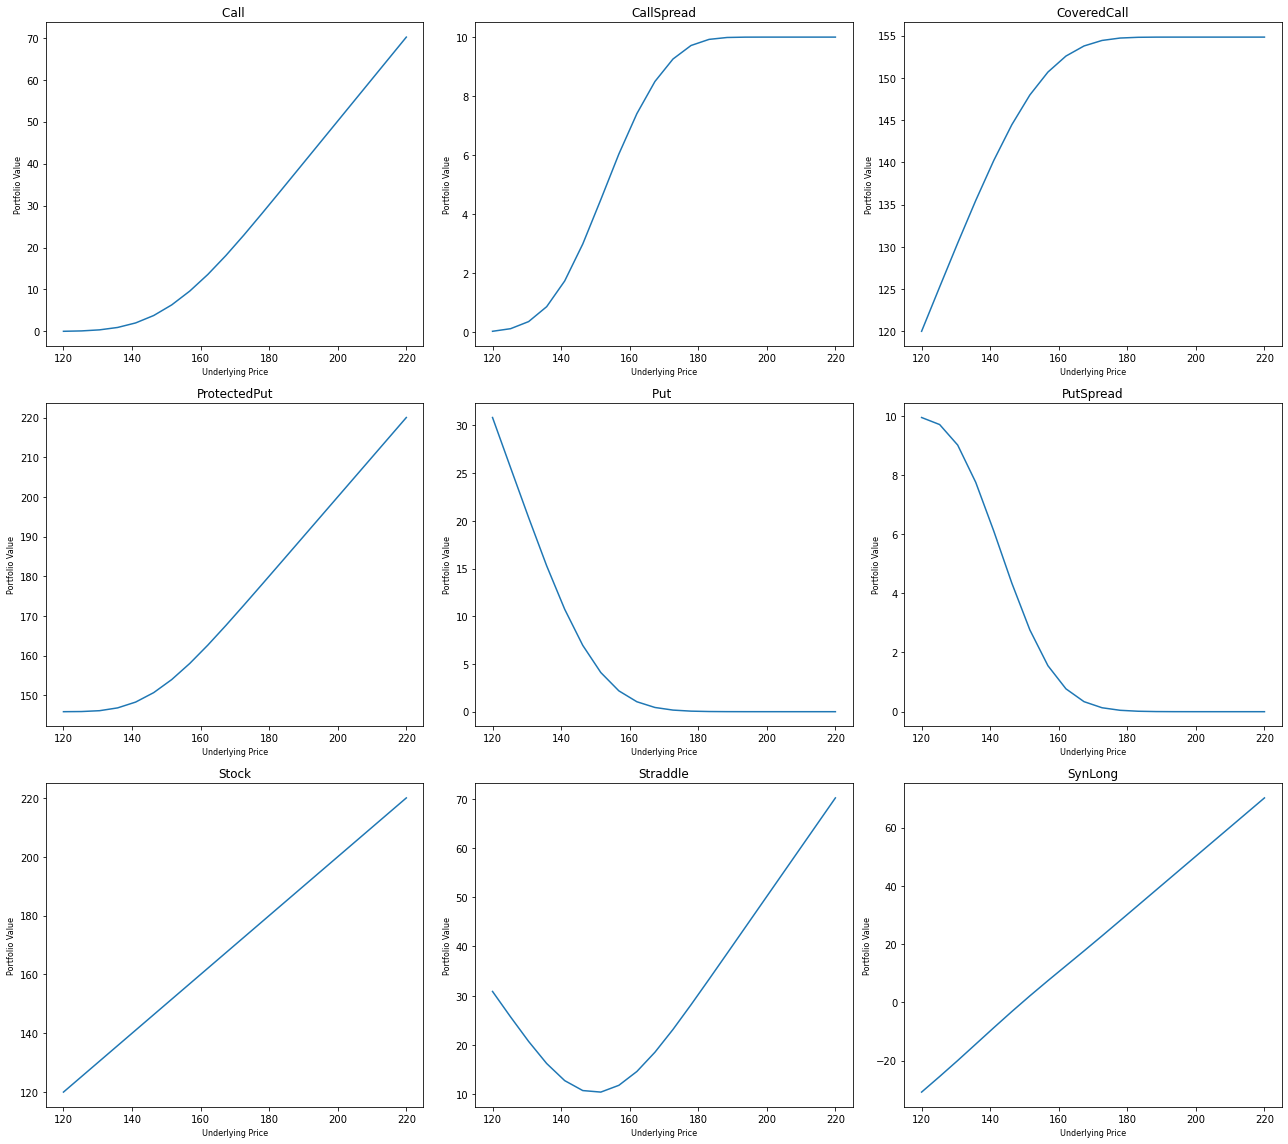

In [12]:
import numpy as np
import pandas as pd
import scipy.optimize
from datetime import datetime
import matplotlib.pyplot as plt

def implied_vol_american(option_type, S0, X, T, div_time, div, r, N, market_price, x0=0.5):
    def equation(implied_vol):
        return binomial_tree(option_type, S0, X, T, div_time, div, implied_vol, r, N) - market_price
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
    sim_values = pd.DataFrame(index=portfolios.index, columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)

    for i in portfolios.index:
        if portfolios["Type"][i] == "Stock":
            single_values = sim_prices
        else:
            option_type = portfolios["OptionType"][i]
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
            implied_vol = portfolios["ImpliedVol"][i]
            div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
            div = 1
            option_values = [binomial_tree(option_type, S, X, T, div_time, div, implied_vol, r, N) for S in sim_prices]
            single_values = np.array(option_values)

        sim_values.loc[i, :] = portfolios["Holding"][i] * single_values

    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

# Reading the data
portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

# Constants
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
    if portfolios["Type"][i] == "Stock":
        implied_vols.append(None)
    else:
        option_type = portfolios["OptionType"][i]
        X = portfolios["Strike"][i]
        T = (portfolios["ExpirationDate"][i] - current_date).days / 365
        div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
        market_price = portfolios["CurrentPrice"][i]
        implied_vol = implied_vol_american(option_type, S, X, T, div_time, div, r, N, market_price)
        implied_vols.append(implied_vol)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 20)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

plt.tight_layout()
plt.show()



In [13]:
import math
import sys
import pandas as pd
import numpy as np

def calculate_returns(data, method="discrete", date_col="Date"):
    assert date_col in data.columns

    price_vars = list(data.columns)
    price_vars.remove(date_col)
    price_data = data[price_vars]

    num_vars = len(price_vars)
    num_rows = len(price_data) - 1

    returns_data = np.zeros(shape=(num_rows, num_vars))
    returns_df = pd.DataFrame(returns_data)

    for i in range(num_rows):
        for j in range(num_vars):
            returns_df.iloc[i, j] = price_data.iloc[i + 1, j] / price_data.iloc[i, j]
            if method == "discrete":
                returns_df.iloc[i, j] -= 1
            elif method == "log":
                returns_df.iloc[i, j] = math.log(returns_df.iloc[i, j])
            else:
                sys.exit(1)

    date_series = data[date_col].drop(index=0)
    date_series.index -= 1

    output = pd.DataFrame({date_col: date_series})

    for i in range(num_vars):
        output[price_vars[i]] = returns_df.iloc[:, i]

    return output



In [14]:

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1
all_prices = pd.read_csv("DailyPrices.csv")
all_returns = calculate_returns(all_prices, method="discrete", date_col="Date")
all_returns

/tmp/ipykernel_4925/1042380426.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output[price_vars[i]] = returns_df.iloc[:, i]


,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,2/15/2022 0:00,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
1,2/16/2022 0:00,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025984
2,2/17/2022 0:00,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030857,-0.031925,-0.033380,-0.028763
3,2/18/2022 0:00,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
4,2/22/2022 0:00,-0.010732,-0.017812,-0.000729,-0.015753,-0.041366,-0.004521,-0.008163,-0.019790,-0.010659,...,0.009494,0.007121,-0.008891,0.003243,-0.001147,-0.000673,0.008342,-0.037654,-0.002246,-0.013605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2/3/2023 0:00,-0.010629,0.024400,-0.023621,-0.084315,0.009083,-0.027474,-0.032904,-0.011866,-0.028053,...,-0.004694,-0.011251,-0.001277,-0.002677,0.038211,0.004134,0.002336,-0.008916,-0.005954,0.001617
244,2/6/2023 0:00,-0.006111,-0.017929,-0.006116,-0.011703,0.025161,-0.017942,-0.016632,-0.002520,-0.000521,...,-0.014451,0.003945,0.001066,-0.007102,0.022012,0.021826,-0.041181,0.005106,-0.009782,-0.004595
245,2/7/2023 0:00,0.013079,0.019245,0.042022,-0.000685,0.010526,0.046064,0.044167,0.029883,0.051401,...,-0.000368,-0.016473,-0.008518,0.019544,-0.003590,-0.001641,0.003573,0.001451,0.008669,-0.003618
246,2/8/2023 0:00,-0.010935,-0.017653,-0.003102,-0.020174,0.022763,-0.076830,-0.074417,-0.042741,0.001443,...,-0.008469,-0.004456,-0.001289,-0.018009,-0.004416,0.002819,-0.015526,0.004106,-0.015391,0.009363


In [15]:
# Simulate the prices based on returns with normal distribution
std = all_returns['AAPL'].std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 100))
sim_prices = 151.03 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T
curr_values

Portfolio
Call              6.80
CallSpread        4.59
CoveredCall     146.98
ProtectedPut    154.04
Put               4.85
PutSpread         3.01
Stock           151.03
Straddle         11.65
SynLong           1.95
Name: CurrentValue, dtype: float64

In [16]:
sim_values

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Portfolio,,,,,,,,,,,,,,,,,,,,,
Call,3.695839,3.720265,8.087474,17.295440,3.882010,11.024748,4.404789,0.183271,10.297609,13.424156,...,2.108312,11.364931,7.145846,1.898569,7.622890,15.309588,4.673119,6.344153,11.496111,10.745083
CallSpread,2.923228,2.939022,5.342852,8.302869,3.043607,6.598507,3.381635,0.177090,6.336518,7.347129,...,1.795440,6.675839,4.940841,1.642513,5.135138,7.920990,3.571751,4.497915,6.705660,6.534152
CoveredCall,144.271456,144.320088,149.668804,153.638474,144.642116,151.590214,145.682947,127.573275,151.136908,152.530417,...,140.528508,151.741252,148.921490,139.775522,149.358184,153.214600,146.083203,148.002283,151.799494,151.432182
ProtectedPut,150.517102,150.551425,156.203137,166.748005,150.778707,159.691818,151.515146,145.948073,158.799442,162.453865,...,148.397155,160.131657,154.989958,148.073110,155.656002,164.535149,151.839474,153.965464,160.301402,159.331653
Put,7.105736,7.065506,2.875073,0.526220,6.799676,1.643945,5.943663,23.230815,1.883585,1.075476,...,10.460803,1.552725,3.401838,11.141777,3.087081,0.751089,5.583675,4.089524,1.517652,1.720217
PutSpread,4.420697,4.400433,2.028566,0.408195,4.266798,1.209348,3.837088,9.446690,1.347637,0.798337,...,5.991510,1.160646,2.340566,6.268087,2.173077,0.574210,3.656448,2.752634,1.134551,1.246640
Stock,146.071334,146.135428,154.626030,166.501306,146.559846,158.856602,147.931612,127.612196,157.813947,161.916878,...,141.401180,159.344395,153.098073,140.531156,153.952871,164.186061,148.510512,151.612346,159.532495,158.455586
Straddle,10.801575,10.785772,10.962547,17.821660,10.681687,12.668693,10.348452,23.414085,12.181194,14.499632,...,12.569115,12.917656,10.547684,13.040346,10.709971,16.060677,10.256795,10.433676,13.013763,12.465301
SynLong,-3.409897,-3.345241,5.212401,16.769220,-2.917666,9.380803,-1.538874,-23.047544,8.414025,12.348680,...,-8.352491,9.812206,3.744008,-9.243207,4.535809,14.558498,-0.910556,2.254629,9.978458,9.024866


In [17]:
def cal_ES(x,alpha=0.05):
    xs = np.sort(x)
    n = alpha * len(xs)
    iup = math.ceil(n)
    idn = math.floor(n)
    VaR = (xs[iup] + xs[idn]) / 2
    ES = xs[0:idn].mean()
    return -VaR,-ES

# Calculate the Mean, VaR and ES, and print the results
resulting_mat = pd.DataFrame(0, index=sim_values.index.values, columns=["Mean", "VaR($)", "ES($)"])
for i in range(len(resulting_mat)):
    resulting_mat.iloc[i,0] = sim_values.iloc[i,:].mean()
    resulting_mat.iloc[i,1], resulting_mat.iloc[i,2] = cal_ES(sim_value_changes.iloc[i,:],alpha=0.05)[0:2]
resulting_mat

,Mean,VaR($),ES($)
Call,6.673385,6.193469,6.562662
CallSpread,4.064113,4.023378,4.362484
CoveredCall,145.246079,13.850938,18.803451
ProtectedPut,154.083535,7.643353,8.041389
Put,6.804384,4.352356,4.649988
PutSpread,3.828833,2.625317,2.854175
Stock,149.519227,17.739029,22.800091
Straddle,13.477769,1.346503,1.385781
SynLong,-0.130999,19.005682,24.336698


In [18]:
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

cal_amr_delta_num = cal_partial_derivative(binomial_tree, 1, 'S0')

# Calculate the deltas for all portfolios
deltas = []
for i in range(len(portfolios.index)):
    if portfolios["Type"][i] == "Stock":
        deltas.append(1)
    else:
        option_type = portfolios["OptionType"][i]
        X = portfolios["Strike"][i]
        T = ((portfolios["ExpirationDate"][i] - current_date).days - 10) / 365
        div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
        delta = cal_amr_delta_num(option_type, S, X, T, div_time, div, implied_vol, r, N)
        deltas.append(delta)

# Store the deltas in portfolios
portfolios["deltas"] = deltas

alpha = 0.05
t = 10
result_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['Mean', 'VaR', 'ES'])
result_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
    gradient = S / df['CurrentValue'].sum() * (df['Holding'] * df['deltas']).sum()
    pfl_10d_std = abs(gradient) * std * np.sqrt(t)
    N = scipy.stats.norm(0, 1)
    present_value = df['CurrentValue'].sum()
    result_dn.loc[pfl]['Mean'] = 0
    result_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
    result_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha

result_dn


,Mean,VaR,ES
Portfolio,,,
Call,0,9.51986,11.938288
CallSpread,0,5.26384,6.601068
CoveredCall,0,10.901461,13.670872
ProtectedPut,0,12.141348,15.225741
Put,0,8.187534,10.267498
PutSpread,0,4.91698,6.166092
Stock,0,17.627131,22.105134
Straddle,0,1.332326,1.67079
SynLong,0,17.707393,22.205786


In [19]:
ff = pd.read_csv('F-F_Research_Data_Factors_daily.csv', parse_dates=['Date']).set_index('Date')
mom = pd.read_csv('F-F_Momentum_Factor_daily.csv', parse_dates=['Date']).set_index('Date')
# transfer percentage to value
data = ff.join(mom, how='right') / 100
data

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
1926-11-03,0.0020,-0.0020,-0.0033,0.00013,0.0056
1926-11-04,0.0059,-0.0012,0.0065,0.00013,-0.0050
1926-11-05,0.0007,-0.0011,0.0026,0.00013,0.0117
1926-11-06,0.0016,-0.0029,0.0005,0.00013,-0.0003
1926-11-08,0.0052,-0.0012,0.0018,0.00013,-0.0001
...,...,...,...,...,...
2023-01-25,0.0000,-0.0004,0.0065,0.00017,0.0014
2023-01-26,0.0108,-0.0058,0.0001,0.00017,-0.0123
2023-01-27,0.0036,0.0062,-0.0116,0.00017,-0.0246


In [20]:
all_prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
all_returns = calculate_returns(all_prices, method="discrete", date_col="Date")

/tmp/ipykernel_4925/1042380426.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output[price_vars[i]] = returns_df.iloc[:, i]


In [21]:
all_returns = all_returns.set_index("Date")

stocks = ['AAPL', 'META', 'UNH', 'MA',  
          'MSFT' ,'NVDA', 'HD', 'PFE',  
          'AMZN' ,'BRK-B', 'PG', 'XOM',  
          'TSLA' ,'JPM' ,'V', 'DIS',  
          'GOOGL', 'JNJ', 'BAC', 'CSCO']
factors = ['Mkt-RF', 'SMB', 'HML', 'RF']
dataset = all_returns[stocks].join(data)

dataset

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,...,DIS,GOOGL,JNJ,BAC,CSCO,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,0.023152,0.015158,0.008073,0.019724,0.018542,0.091812,0.004836,-0.000201,0.008658,0.006109,...,0.025655,0.007987,0.010326,0.007803,0.020496,0.0187,0.0133,-0.0142,0.0,-0.0091
2022-02-16,-0.001389,-0.020181,0.003806,0.003643,-0.001167,0.000604,-0.008974,-0.002209,0.010159,-0.001739,...,0.010535,0.008268,-0.000598,-0.002302,-0.000369,-0.0002,-0.0009,0.0031,0.0,0.0064
2022-02-17,-0.021269,-0.040778,-0.020227,-0.024103,-0.029282,-0.075591,-0.006141,-0.015700,-0.021809,-0.006653,...,-0.021746,-0.037746,-0.006100,-0.033767,0.028018,-0.0228,-0.0028,0.0110,0.0,0.0103
2022-02-18,-0.009356,-0.007462,-0.005379,-0.010035,-0.009631,-0.035296,-0.003075,-0.007566,-0.013262,0.003987,...,-0.010396,-0.016116,-0.010719,-0.002388,0.025820,-0.0087,-0.0009,0.0093,0.0,0.0104
2022-02-22,-0.017812,-0.019790,-0.011329,-0.004487,-0.000729,-0.010659,-0.088506,-0.020606,-0.015753,-0.002033,...,-0.021604,-0.004521,-0.013590,-0.008703,-0.015906,-0.0118,-0.0048,0.0011,0.0,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-03,0.024400,-0.011866,0.002527,-0.002747,-0.023621,-0.028053,-0.024397,-0.006315,-0.084315,-0.010742,...,-0.022083,-0.027474,-0.005618,0.008303,-0.013990,NaN,NaN,NaN,NaN,NaN
2023-02-06,-0.017929,-0.002520,0.006822,-0.002514,-0.006116,-0.000521,-0.006727,-0.006809,-0.011703,-0.000259,...,-0.007587,-0.017942,-0.007594,-0.001647,-0.021797,NaN,NaN,NaN,NaN,NaN
2023-02-07,0.019245,0.029883,0.003451,0.005604,0.042022,0.051401,-0.012361,-0.003885,-0.000685,0.014720,...,0.016019,0.046064,0.000245,0.010998,0.005676,NaN,NaN,NaN,NaN,NaN


In [22]:
dataset = dataset.drop(dataset['2023-02'].index)
# calculate arithmetic E(r) in past 10 years
avg_factor_rets = data.loc['2013-1-31':'2023-1-31'].mean(axis=0)
dataset['RF']

/tmp/ipykernel_4925/2090827049.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  dataset = dataset.drop(dataset['2023-02'].index)


Date
2022-02-15    0.00000
2022-02-16    0.00000
2022-02-17    0.00000
2022-02-18    0.00000
2022-02-22    0.00000
               ...   
2023-01-25    0.00017
2023-01-26    0.00017
2023-01-27    0.00017
2023-01-30    0.00017
2023-01-31    0.00017
Name: RF, Length: 241, dtype: float64

In [23]:
avg_daily_rets = pd.Series()
for stock in stocks:
  # calculate betas
  model = sm.OLS(dataset[stock] - dataset['RF'], sm.add_constant(dataset[factors]))
  results = model.fit()
    
  # assume alpha = 0
  avg_daily_rets[stock] = (results.params[factors] * avg_factor_rets[factors]).sum() \
                          + avg_factor_rets['RF'] 
# geometric annual returns: mean and covariance
geo_means = np.log(1 + avg_daily_rets) * 255  
geo_covariance = np.log(1 + all_returns[stocks]).cov() * 255
print(geo_means)

AAPL     0.093860
META     0.361449
UNH     -0.069173
MA       0.191821
MSFT     0.111293
NVDA     0.464330
HD       0.199479
PFE     -0.029811
AMZN     0.151040
BRK-B    0.111360
PG       0.111582
XOM      0.043400
TSLA    -0.104159
JPM      0.300436
V        0.189308
DIS      0.309686
GOOGL    0.151795
JNJ     -0.054679
BAC      0.264885
CSCO     0.189703
dtype: float64


/tmp/ipykernel_4925/369180229.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_daily_rets = pd.Series()


In [24]:
display(geo_covariance)

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.128246,0.140937,0.038023,0.082088,0.103897,0.172692,0.066959,0.033173,0.123708,0.056022,0.037345,0.038147,0.157866,0.059013,0.072188,0.088897,0.112945,0.023075,0.066731,0.067180
META,0.140937,0.411026,0.018367,0.103053,0.142862,0.239855,0.098138,0.045985,0.196275,0.062163,0.033651,0.021535,0.174400,0.074515,0.085722,0.127741,0.182850,0.021579,0.089351,0.076749
UNH,0.038023,0.018367,0.061611,0.031595,0.036898,0.047420,0.026547,0.032334,0.035881,0.028490,0.028227,0.027064,0.040104,0.033573,0.030066,0.023097,0.030186,0.023156,0.034892,0.029052
MA,0.082088,0.103053,0.031595,0.096915,0.080480,0.138713,0.057341,0.033996,0.097883,0.048081,0.031367,0.031441,0.099282,0.058904,0.083352,0.078440,0.079764,0.017590,0.064155,0.052342
MSFT,0.103897,0.142862,0.036898,0.080480,0.129167,0.177343,0.071625,0.035653,0.135754,0.053157,0.034155,0.031611,0.133225,0.057109,0.068781,0.089231,0.121430,0.020589,0.065723,0.061489
NVDA,0.172692,0.239855,0.047420,0.138713,0.177343,0.407025,0.112860,0.047246,0.224330,0.085227,0.042123,0.055951,0.296126,0.099161,0.119489,0.160085,0.189077,0.022202,0.114655,0.099237
HD,0.066959,0.098138,0.026547,0.057341,0.071625,0.112860,0.098986,0.033926,0.098223,0.042737,0.034923,0.016048,0.078976,0.044037,0.050704,0.064859,0.070178,0.022762,0.047094,0.049084
PFE,0.033173,0.045985,0.032334,0.033996,0.035653,0.047246,0.033926,0.071198,0.038388,0.031553,0.027785,0.020229,0.022972,0.032183,0.031103,0.025121,0.029718,0.027901,0.031194,0.029802
AMZN,0.123708,0.196275,0.035881,0.097883,0.135754,0.224330,0.098223,0.038388,0.247855,0.066712,0.030875,0.038063,0.189997,0.071779,0.084987,0.126627,0.151784,0.023180,0.086443,0.072748
BRK-B,0.056022,0.062163,0.028490,0.048081,0.053157,0.085227,0.042737,0.031553,0.066712,0.050579,0.025080,0.034286,0.062583,0.047378,0.042566,0.052010,0.056800,0.019427,0.051168,0.040908


In [25]:
# arithmetic annual returns: mean and covariance
arith_means = np.exp(geo_means + np.diagonal(geo_covariance.values) / 2) - 1

nstocks = geo_covariance.shape[0]
arith_covariance = np.empty((nstocks, nstocks), dtype=float)
for i in range(nstocks):
  for j in range(i, nstocks):
    mu_i, mu_j = geo_means.iloc[i], geo_means.iloc[j]
    sigma2_i, sigma2_j = geo_covariance.iloc[i, i], geo_covariance.iloc[j, j]
    sigma_ij = geo_covariance.iloc[i, j]
    arith_covariance[i, j] = np.exp(mu_i + mu_j + (sigma2_i + sigma2_j) / 2) * (np.exp(sigma_ij) - 1)
    arith_covariance[j, i] = arith_covariance[i, j]
arith_covariance = pd.DataFrame(arith_covariance, columns=stocks, index=stocks)

print(arith_means)

AAPL     0.171146
META     0.762903
UNH     -0.037641
MA       0.271602
MSFT     0.192290
NVDA     0.950026
HD       0.282706
PFE      0.005805
AMZN     0.316488
BRK-B    0.146426
PG       0.145970
XOM      0.110124
TSLA     0.139654
JPM      0.407970
V        0.260227
DIS      0.462612
GOOGL    0.262884
JNJ     -0.038059
BAC      0.371124
CSCO     0.263864
dtype: float64


In [26]:
display(arith_covariance)

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.187678,0.312484,0.043679,0.127405,0.152881,0.430491,0.104033,0.039731,0.203032,0.077363,0.051068,0.050553,0.228246,0.100238,0.110482,0.159249,0.176847,0.026298,0.110812,0.102854
META,0.312484,1.579908,0.031448,0.243338,0.322789,0.931842,0.233174,0.083442,0.503301,0.129622,0.069139,0.042602,0.382796,0.192019,0.198846,0.351335,0.446682,0.036992,0.225918,0.177735
UNH,0.043679,0.031448,0.058855,0.039281,0.043127,0.091133,0.033209,0.031809,0.046285,0.031884,0.031573,0.029309,0.044878,0.046263,0.037018,0.032889,0.037246,0.021686,0.046853,0.035854
MA,0.127405,0.243338,0.039281,0.164553,0.127062,0.368959,0.096262,0.044228,0.172149,0.071805,0.046433,0.045088,0.151263,0.108628,0.139296,0.151763,0.133338,0.021706,0.115522,0.086362
MSFT,0.152881,0.322789,0.043127,0.127062,0.196004,0.451145,0.113558,0.043527,0.228225,0.074625,0.047474,0.042509,0.193638,0.098659,0.106985,0.162759,0.194404,0.023858,0.111051,0.095565
NVDA,0.430491,0.931842,0.091133,0.368959,0.451145,1.910206,0.298844,0.094890,0.645605,0.198885,0.096143,0.124574,0.765912,0.286210,0.311906,0.495162,0.512562,0.042113,0.324821,0.257123
HD,0.104033,0.233174,0.033209,0.096262,0.113558,0.298844,0.171198,0.044521,0.174285,0.064209,0.052242,0.023037,0.120132,0.081309,0.084076,0.125715,0.117765,0.028407,0.084807,0.081559
PFE,0.039731,0.083442,0.031809,0.044228,0.043527,0.094890,0.044521,0.074653,0.051819,0.036963,0.032475,0.022817,0.026637,0.046317,0.040044,0.037424,0.038315,0.027375,0.043697,0.038455
AMZN,0.203032,0.503301,0.046285,0.172149,0.228225,0.645605,0.174285,0.051819,0.487487,0.104121,0.047306,0.056700,0.313940,0.137938,0.147164,0.259931,0.272511,0.029698,0.162978,0.125555
BRK-B,0.077363,0.129622,0.031884,0.071805,0.074625,0.198885,0.064209,0.036963,0.104121,0.068186,0.033367,0.044392,0.084380,0.078316,0.062826,0.089518,0.084616,0.021634,0.082524,0.060501


In [27]:
# calculate the most efficient portfolio which has the highest Sharpe ratio 
def neg_sharpe_ratio(weights, mean, cov, r):
  returns = mean @ weights.T
  std = np.sqrt(weights @ cov @ weights.T)
  return -(returns - r) / std

args = (arith_means, arith_covariance, 0.0025)
bounds = [(0.0, 1) for _ in stocks]
x0 = np.array(nstocks*[1 / nstocks])
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}
results = scipy.optimize.minimize(neg_sharpe_ratio, x0=x0, args=args, bounds=bounds, constraints=constraints)
opt_sharpe, opt_weights = -results.fun, pd.Series(results.x, index=stocks)
opt_weights = pd.DataFrame(opt_weights, columns=['weights(%)'])
opt_weights['weights(%)'] = round(opt_weights*100, 2)

print("The most efficient portfolio consists of: ")
display(opt_weights)
print("The Portfolio's Sharpe Ratio is: " + str(opt_sharpe))

The most efficient portfolio consists of: 


,weights(%)
AAPL,0.00
META,4.27
UNH,0.00
MA,0.00
MSFT,0.00
NVDA,0.63
HD,7.76
PFE,0.00
AMZN,0.00
BRK-B,0.00


The Portfolio's Sharpe Ratio is: 1.046214029644052
